# Project_Break_II_ML

# Flights Delay Prediction

<img src="src/img/openart_image_1_1.jpg" width="1200"/>


This work aims to use a dataset on flights, geolocation, and meteorological indicators to predict possible delays. The dataset used was obtained from the following Kaggle page: https://www.kaggle.com/datasets/bordanova/2023-us-civil-flights-delay-meteo-and-aircraft/data

## General Objectives:
- (1) Prediction of whether a flight will be delayed at takeoff;
- (2) Prediction of the takeoff time;
- (3) Prediction of the arrival time at the destination airport;

## Specific Objectives:
- (1) A binary classifier to classify delayed flights (class 1) and on-time flights (class 0) within a 15-minute tolerance beyond the scheduled time. For this objective, only logistical data available since the flight booking and weather forecasts will be used, without real-time updates immediately before takeoff. This makes the classifier very challenging but provides a highly important predictive potential, as it helps identify delay patterns that are independent of unpredictable, stochastic, and uncontrollable events;

- (2) A linear regression model to predict the actual takeoff time. Similar to the previous case, but with a continuous extension of the takeoff time, not just predicting whether it will be more or less than 15 minutes delayed. This prediction is highly relevant, as there is a significant discrepancy between possible delays that are not predicted by a classifier;

- (3) Prediction of the arrival time at the destination airport once the actual takeoff time is known.


https://www.kaggle.com/datasets/bordanova/2023-us-civil-flights-delay-meteo-and-aircraft/data

-------------------------------

# Objective 1: *Departure Delay Classification*

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_columns', None)

Importing Personalized Tools

In [3]:
import sys
import os

sys.path.append(os.path.abspath('src'))

from utils.User_Functions import *

Importing Datasets

In [4]:
df_flights = pd.read_csv("./src/data/US_flights_2023.csv")
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6743404 entries, 0 to 6743403
Data columns (total 24 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   FlightDate          object
 1   Day_Of_Week         int64 
 2   Airline             object
 3   Tail_Number         object
 4   Dep_Airport         object
 5   Dep_CityName        object
 6   DepTime_label       object
 7   Dep_Delay           int64 
 8   Dep_Delay_Tag       int64 
 9   Dep_Delay_Type      object
 10  Arr_Airport         object
 11  Arr_CityName        object
 12  Arr_Delay           int64 
 13  Arr_Delay_Type      object
 14  Flight_Duration     int64 
 15  Distance_type       object
 16  Delay_Carrier       int64 
 17  Delay_Weather       int64 
 18  Delay_NAS           int64 
 19  Delay_Security      int64 
 20  Delay_LastAircraft  int64 
 21  Manufacturer        object
 22  Model               object
 23  Aicraft_age         int64 
dtypes: int64(11), object(13)
memory usage: 1.2+ GB


In [5]:
df_weather = pd.read_csv("./src/data/weather_meteo_by_airport.csv")
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132860 entries, 0 to 132859
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        132860 non-null  object 
 1   tavg        132860 non-null  float64
 2   tmin        132860 non-null  float64
 3   tmax        132860 non-null  float64
 4   prcp        132860 non-null  float64
 5   snow        132860 non-null  float64
 6   wdir        132860 non-null  float64
 7   wspd        132860 non-null  float64
 8   pres        132860 non-null  float64
 9   airport_id  132860 non-null  object 
dtypes: float64(8), object(2)
memory usage: 10.1+ MB


In [6]:
df_location = pd.read_csv("./src/data/airports_geolocation.csv")
df_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  364 non-null    object 
 1   AIRPORT    364 non-null    object 
 2   CITY       364 non-null    object 
 3   STATE      364 non-null    object 
 4   COUNTRY    364 non-null    object 
 5   LATITUDE   364 non-null    float64
 6   LONGITUDE  364 non-null    float64
dtypes: float64(2), object(5)
memory usage: 20.0+ KB


In [7]:
# Converting FlightDate and time to datetime
df_flights['FlightDate'] = pd.to_datetime(df_flights['FlightDate'], errors='coerce')
df_weather['time'] = pd.to_datetime(df_weather['time'], errors='coerce')

# Merging DataFrames df_flights, df_location, df_weather
merged_df = pd.merge(df_flights, df_location,
                    how='left',
                    left_on=['Dep_Airport'],
                    right_on=['IATA_CODE'])

merged_df = pd.merge(merged_df, df_weather,
                      how='left',
                      left_on=['Dep_Airport', 'FlightDate'],
                      right_on=['airport_id', 'time'])


In [8]:
merged_df.sample(3)

,FlightDate,Day_Of_Week,Airline,Tail_Number,Dep_Airport,Dep_CityName,DepTime_label,Dep_Delay,Dep_Delay_Tag,Dep_Delay_Type,Arr_Airport,Arr_CityName,Arr_Delay,Arr_Delay_Type,Flight_Duration,Distance_type,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,Manufacturer,Model,Aicraft_age,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,airport_id
3502360,2023-07-04,2,Delta Air Lines Inc,N365NW,ROC,"Rochester, NY",Afternoon,-5,0,Low <5min,ATL,"Atlanta, GA",-23,Low <5min,117,Short Haul >1500Mi,0,0,0,0,0,AIRBUS,A320,25,ROC,Greater Rochester International Airport,Rochester,NY,USA,43.11887,-77.67238,2023-07-04,22.5,16.1,30.0,0.0,0.0,299.0,7.2,1014.4,ROC
5914738,2023-11-19,7,PSA Airlines,N603NN,DCA,"Washington, DC",Morning,1,1,Low <5min,VPS,"Valparaiso, FL",-22,Low <5min,147,Short Haul >1500Mi,0,0,0,0,0,CANADAIR REGIONAL JET,CRJ,5,DCA,Ronald Reagan Washington National Airport,Arlington,VA,USA,38.85208,-77.03772,2023-11-19,9.9,3.9,16.1,0.0,0.0,303.0,8.3,1016.8,DCA
6021392,2023-11-22,3,Skywest Airlines Inc.,N717EV,IDA,"Idaho Falls, ID",Afternoon,5,1,Low <5min,DFW,"Dallas/Fort Worth, TX",5,Low <5min,171,Short Haul >1500Mi,0,0,0,0,0,CANADAIR REGIONAL JET,CRJ,21,IDA,Idaho Falls Regional Airport,Idaho Falls,ID,USA,43.51456,-112.07017,2023-11-22,0.0,-6.7,6.7,0.0,0.0,347.0,6.5,1028.6,IDA


| Field               | Description                                               | Example                               |
|---------------------|-----------------------------------------------------------|---------------------------------------|
| FlightDate         | The date of the flight.                                    | 2024-09-09                           |
| Day_Of_Week        | The day of the week when the flight occurred.              | Monday                               |
| Airline           | The name or code of the airline operating the flight.      | AA for American Airlines             |
| Tail_Number       | The unique identifier (registration number) of the aircraft. | N123AA                               |
| Dep_Airport       | The IATA code of the departure airport.                    | JFK                                  |
| Dep_CityName      | The name of the city where the departure airport is located. | New York                             |
| DepTime_label     | The categorized or labeled departure time.                 | Morning                              |
| Dep_Delay        | The number of minutes the flight was delayed at departure.  | 1                                   |
| Dep_Delay_Tag    | Categorical representation of the departure delay.          | On-time                              |
| Dep_Delay_Type   | The type or reason for the departure delay.                 | Operational                          |
| Arr_Airport      | The IATA code of the arrival airport.                       | LAX                                  |
| Arr_CityName     | The name of the city where the arrival airport is located.  | Los Angeles                          |
| Arr_Delay       | The number of minutes the flight was delayed at arrival.     | 10                                   |
| Arr_Delay_Type  | The type or reason for the arrival delay.                    | Weather                              |
| Flight_Duration | The duration of the flight.                                  | 300 minutes                          |
| Distance_type   | The classification of flight distance.                       | Long-haul                            |
| Delay_Carrier   | The number of minutes the delay is attributed to the airline/carrier. | 5                          |
| Delay_Weather   | The number of minutes the delay is attributed to weather conditions. | 10                         |
| Delay_NAS       | The number of minutes the delay is attributed to National Airspace System issues. | 0 |
| Delay_Security  | The number of minutes the delay is attributed to security-related issues. | 0 |
| Delay_LastAircraft | The number of minutes the delay is attributed to delays in the aircraft's previous flight. | 20 |
| Manufacturer    | The company that manufactured the aircraft.                   | Boeing                               |
| Model          | The model of the aircraft.                                     | Boeing 737                           |
| Aircraft_age   | The age of the aircraft in years.                             | 12 years                             |
| time           | The specific time or timestamp associated with the flight record. | 12:30 PM                         |
| tavg           | The average temperature on the day of the flight.             | 22°C                                 |
| tmin           | The minimum temperature on the day of the flight.             | 18°C                                 |
| tmax           | The maximum temperature on the day of the flight.             | 28°C                                 |
| prcp           | The amount of precipitation on the day of the flight.         | 2 mm                                 |
| snow           | The amount of snowfall on the day of the flight.              | 0 mm                                 |
| wdir           | The wind direction.                                           | 270°                                 |
| wspd           | The wind speed.                                               | 15 km/h                              |
| pres           | The atmospheric pressure.                                     | 1015 hPa                             |
| airport_id     | A unique identifier for the airport.                          | 12345                                |
| IATA_CODE      | The International Air Transport Association code for the airport. | JFK                            |
| AIRPORT        | The name of the airport.                                      | John F. Kennedy International Airport |
| CITY           | The city where the airport is located.                        | New York                             |
| STATE          | The state or region where the airport is located.             | NY                                   |
| COUNTRY        | The country where the airport is located.                     | USA                                  |
| LATITUDE       | The latitude coordinate of the airport.                       | 40.6413° N                           |
| LONGITUDE      | The longitude coordinate of the airport.                      | 73.7781° W                           |


In [9]:
# Dropping redundant and unnecessary columns
merged_df.drop(columns=["IATA_CODE", "AIRPORT", "CITY", "STATE", "COUNTRY", "time", "airport_id"], inplace=True)

In [10]:
# Splitting FlightDate into Day and Month columns
merged_df['Month'] = merged_df['FlightDate'].dt.month
merged_df['Day'] = merged_df['FlightDate'].dt.day
merged_df.drop(columns=["FlightDate"], inplace=True)
merged_df.sample(2)


,Day_Of_Week,Airline,Tail_Number,Dep_Airport,Dep_CityName,DepTime_label,Dep_Delay,Dep_Delay_Tag,Dep_Delay_Type,Arr_Airport,Arr_CityName,Arr_Delay,Arr_Delay_Type,Flight_Duration,Distance_type,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,Manufacturer,Model,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Month,Day
5314675,7,Republic Airways,N755YX,MYR,"Myrtle Beach, SC",Evening,0,0,Low <5min,EWR,"Newark, NJ",-1,Low <5min,128,Short Haul >1500Mi,0,0,0,0,0,EMBRAER,170/175,2,33.67975,-78.92833,17.4,13.3,20.6,0.0,0.0,322.0,16.1,1005.0,10,15
4338557,1,Southwest Airlines Co.,N8801Q,PDX,"Portland, OR",Afternoon,11,1,Low <5min,MDW,"Chicago, IL",0,Low <5min,224,Medium Haul <3000Mi,0,0,0,0,0,BOEING,737 NG,5,45.58872,-122.59750,21.1,17.8,21.7,0.8,0.0,321.0,8.6,1019.2,8,28


#### Analysing merged_df data

The function ```type_variables``` below analyzes the nature of the data in each column and classifies them as numerical, categorical, and "ID-like" features, which are categorical features represented as numbers.

In [11]:
features_num, features_cat, features_id = type_features(merged_df)

print("Numerical features:", features_num)
print("Categorical features:", features_cat)
print("ID features (numeric categoricals):", features_id)

Numerical features: ['Day_Of_Week', 'Dep_Delay', 'Dep_Delay_Tag', 'Arr_Delay', 'Flight_Duration', 'Delay_Carrier', 'Delay_Weather', 'Delay_NAS', 'Delay_Security', 'Delay_LastAircraft', 'Aicraft_age', 'LATITUDE', 'LONGITUDE', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres', 'Month', 'Day']
Categorical features: ['Airline', 'Tail_Number', 'Dep_Airport', 'Dep_CityName', 'DepTime_label', 'Dep_Delay_Type', 'Arr_Airport', 'Arr_CityName', 'Arr_Delay_Type', 'Distance_type', 'Manufacturer', 'Model']
ID features (numeric categoricals): []


Select only logistical variables available in advance + weather forecasts.

In [12]:
features_num = ['Day_Of_Week', 'Flight_Duration', 'Aicraft_age', 
                'LATITUDE', 'LONGITUDE', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres', 'Month', 'Day']

features_cat = ["Airline", "Tail_Number", "Dep_Airport", "DepTime_label", "Arr_Airport", "Distance_type", 
                "Manufacturer", "Model"]

features_id = []

categorical_features = features_cat


| Field            | Description                                           | Example                               |
|------------------|-------------------------------------------------------|---------------------------------------|
| Day_Of_Week     | The day of the week when the flight occurred.         | Monday                               |
| Flight_Duration | The duration of the flight.                           | 300 minutes                          |
| Aircraft_age    | The age of the aircraft in years.                     | 12 years                             |
| Airline         | The name or code of the airline operating the flight. | AA for American Airlines             |
| Tail_Number     | The unique identifier of the aircraft.                | N123AA                               |
| Dep_Airport     | The IATA code of the departure airport.               | JFK                                  |
| DepTime_label   | The categorized or labeled departure time.            | Morning                              |
| Arr_Airport     | The IATA code of the arrival airport.                 | LAX                                  |
| Distance_type   | The classification of flight distance.                | Long-haul                            |
| Manufacturer    | The company that manufactured the aircraft.           | Boeing                               |
| Model          | The model of the aircraft.                             | Boeing 737                           |
| LATITUDE        | The latitude coordinate of the airport.               | 40.6413° N                           |
| LONGITUDE       | The longitude coordinate of the airport.              | 73.7781° W                           |
| tavg            | The average temperature on the day of the flight.     | 22°C                                 |
| tmin            | The minimum temperature on the day of the flight.     | 18°C                                 |
| tmax            | The maximum temperature on the day of the flight.     | 28°C                                 |
| prcp            | The amount of precipitation on the day of the flight. | 2 mm                                 |
| snow            | The amount of snowfall on the day of the flight.      | 0 mm                                 |
| wdir            | The wind direction.                                   | 270°                                 |
| wspd            | The wind speed.                                       | 15 km/h                              |
| pres            | The atmospheric pressure.                             | 1015 hPa                             |



Declaring target for binary classification of departure delay

In [13]:
target_class = "Dep_Delay_Tag"

In [14]:
# Counting nulls
df = merged_df[features_num + features_cat + [target_class]].copy()
df.isnull().sum()

Day_Of_Week        0
Flight_Duration    0
Aicraft_age        0
LATITUDE           0
LONGITUDE          0
tavg               0
tmin               0
tmax               0
prcp               0
snow               0
wdir               0
wspd               0
pres               0
Month              0
Day                0
Airline            0
Tail_Number        0
Dep_Airport        0
DepTime_label      0
Arr_Airport        0
Distance_type      0
Manufacturer       0
Model              0
Dep_Delay_Tag      0
dtype: int64

In [15]:
# Looking for the target proportion
df[target_class].value_counts(normalize=True)

Dep_Delay_Tag
0    0.620999
1    0.379001
Name: proportion, dtype: float64

In [16]:
import pandas as pd

# Função para exibir os valores únicos e o percentual de valores únicos das colunas categóricas
def display_unique_counts(df, features_cat):
    # Para cada coluna categórica na lista
    for col in features_cat:
        # Conta o número total de valores únicos da coluna
        num_unique_values = df[col].nunique()
        
        # Calcula o número total de valores da coluna
        total_values = len(df[col])
        
        # Calcula o percentual de valores únicos em relação ao total de valores da coluna
        percentage_unique = (num_unique_values / total_values) * 100
        
        # Exibe o número de valores únicos e o percentual
        print(f"\nColumn: '{col}'")
        print(f"Number of unique values: {num_unique_values}")
        print(f"Percentage of unique values: {percentage_unique:.2f}%")

# Exemplo de uso
# Suponha que 'df' seja o seu DataFrame e 'features_cat' a lista das colunas categóricas
features_cat = ["Airline", "Tail_Number", "Dep_Airport", "DepTime_label", "Arr_Airport", "Distance_type", 
                "Manufacturer", "Model"]

# Chame a função passando o DataFrame 'df' e a lista 'features_cat'
display_unique_counts(df, features_cat)






Column: 'Airline'
Number of unique values: 15
Percentage of unique values: 0.00%

Column: 'Tail_Number'
Number of unique values: 5963
Percentage of unique values: 0.09%

Column: 'Dep_Airport'
Number of unique values: 350
Percentage of unique values: 0.01%

Column: 'DepTime_label'
Number of unique values: 4
Percentage of unique values: 0.00%

Column: 'Arr_Airport'
Number of unique values: 350
Percentage of unique values: 0.01%

Column: 'Distance_type'
Number of unique values: 3
Percentage of unique values: 0.00%

Column: 'Manufacturer'
Number of unique values: 5
Percentage of unique values: 0.00%

Column: 'Model'
Number of unique values: 21
Percentage of unique values: 0.00%


In [39]:
features_one_hot = ['DepTime_label', 'Distance_type', 'Manufacturer']

features_one_hot = ['Airline', 'DepTime_label', 'Distance_type', 'Manufacturer']

Randomly reducing the dataset to 25% size for computational performance during the following modeling processes

In [40]:
from sklearn.utils import resample

# Random subsampling
data_sample = resample(df, replace=False, n_samples=int(len(df) * 0.25), random_state=42)

print("Original Dataset size:", len(df))
print("Dataset size after subsampling:", len(data_sample))

Original Dataset size: 6743404
Dataset size after subsampling: 1685851


### Target Encoding with K-Fold

The **`target_encoding_kfold`** function applies **Target Encoding** with **K-Fold Cross Validation** to prevent **data leakage** during training, ensuring the model only learns from training data.

---

#### Key Steps:

1. **K-Fold Validation**:
   - Splits the training data into **n_splits** (default 5) using **StratifiedKFold** to ensure balanced target distribution.
   - Prevents **data leakage** by ensuring encoding is only based on training data.

2. **Resetting Indices**:
   - Resets indices in both train and validation sets to avoid **index misalignment** when applying target encoding.

3. **Smoothing**:
   - Calculates the category mean with a smoothing technique that combines the category mean with the global mean to handle sparse categories.

4. **Mapping and Handling Unseen Categories**:
   - Categories in validation and test sets are **mapped** to the calculated target mean; missing categories are assigned the **global mean** to avoid errors.

---

#### Why K-Fold?

- **K-Fold** ensures that encoding is done only with training data, preventing future data from contaminating the model and causing **data leakage**.

---

This approach guarantees **robust target encoding**, preserves model integrity, and prevents **overfitting**.


Dividing train and test set

In [41]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data_sample, test_size=0.2, random_state=42)
print(train_set.shape)
print(test_set.shape)

(1348680, 24)
(337171, 24)


The following cell counts how many categorical values exist in the test set but not in the train set. High values may indicate issues for target encoding strategy, as unseen values in the test set will be assigned the global mean.

In [42]:
# Check non correspondenting values in test set/train set
non_correspondence = {col: {'unique': [], 'absolute': []} for col in categorical_features}

# Iterate over the categorical columns
for col in categorical_features:
    # Identify unique values in test_set that are not in train_set
    test_values = set(test_set[col])
    train_values = set(train_set[col])
    
    # Values in test_set but not in train_set
    non_matching_values = test_values - train_values
    
    # Count the number of unique values and the absolute count of these values
    non_correspondence[col]['unique'] = len(non_matching_values)
    non_correspondence[col]['absolute'] = sum(test_set[col].isin(non_matching_values))
    
# Convert the dictionary to a DataFrame
non_correspondence_df = pd.DataFrame(non_correspondence)
non_correspondence_df



,Airline,Tail_Number,Dep_Airport,Arr_Airport,Model
unique,0,2,0,0,0
absolute,0,2,0,0,0


In [43]:
categorical_features = [col for col in features_cat if col not in features_one_hot]

In [44]:
train_encoded, test_encoded, encoded_columns = target_encoding_kfold(train_set, test_set, categorical_features, target_class, n_splits=5, smoothing=0.3, seed=42)

print("Encoded columns by target_encoding_kfold:", encoded_columns)


Encoded columns by target_encoding_kfold: ['Tail_Number_te', 'Dep_Airport_te', 'Arr_Airport_te', 'Model_te']


Randomly reducing the train_set to 25% size for computational performance during the following modeling process.

In [45]:
# Random subsampling: reduces the training set size to 50%
from sklearn.utils import resample

train_set_subsampled = resample(train_encoded, replace=False, n_samples=int(len(train_set) * 0.25), random_state=42)

print("Original train_set size:", len(train_set))
print("Train_set size after subsampling:", len(train_set_subsampled))

Original train_set size: 1348680
Train_set size after subsampling: 337170


In [46]:
train_set_subsampled.sample(2)

,Day_Of_Week,Flight_Duration,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Month,Day,Airline,DepTime_label,Distance_type,Manufacturer,Dep_Delay_Tag,Tail_Number_te,Dep_Airport_te,Arr_Airport_te,Model_te
2514009,1,85,20,33.64044,-84.42694,19.9,17.2,21.7,8.7,0.0,74.0,12.0,1017.0,5,22,Southwest Airlines Co.,Evening,Short Haul >1500Mi,BOEING,1,0.509310,0.387614,0.373603,0.435378
2823237,5,317,7,45.58872,-122.59750,19.4,12.8,26.7,0.0,0.0,339.0,9.0,1020.9,6,16,Alaska Airlines Inc.,Evening,Medium Haul <3000Mi,BOEING,0,0.402324,0.296327,0.387149,0.435724


In [47]:
from sklearn.preprocessing import OneHotEncoder

# Initialization of OneHotEncoder
ohe_encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' avoids multicollinearity

# Applying OneHotEncoder only to the specified columns
ohe_encoded = ohe_encoder.fit_transform(train_set_subsampled[features_one_hot])

# Converting the data to a DataFrame with appropriate names
ohe_feature_names = [f'ohe_{col}' for col in ohe_encoder.get_feature_names_out(features_one_hot)]
ohe_df = pd.DataFrame(ohe_encoded, columns=ohe_feature_names, index=train_set_subsampled.index)

# Concatenating to the original dataset, removing the original columns
train_set_subsampled = train_set_subsampled.drop(columns=features_one_hot).join(ohe_df)

# Display the result
train_set_subsampled.head()



,Day_Of_Week,Flight_Duration,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Month,Day,Dep_Delay_Tag,Tail_Number_te,Dep_Airport_te,Arr_Airport_te,Model_te,ohe_Airline_Allegiant Air,ohe_Airline_American Airlines Inc.,ohe_Airline_American Eagle Airlines Inc.,ohe_Airline_Delta Air Lines Inc,ohe_Airline_Endeavor Air,ohe_Airline_Frontier Airlines Inc.,ohe_Airline_Hawaiian Airlines Inc.,ohe_Airline_JetBlue Airways,ohe_Airline_PSA Airlines,ohe_Airline_Republic Airways,ohe_Airline_Skywest Airlines Inc.,ohe_Airline_Southwest Airlines Co.,ohe_Airline_Spirit Air Lines,ohe_Airline_United Air Lines Inc.,ohe_DepTime_label_Evening,ohe_DepTime_label_Morning,ohe_DepTime_label_Night,ohe_Distance_type_Medium Haul <3000Mi,ohe_Distance_type_Short Haul >1500Mi,ohe_Manufacturer_BOEING,ohe_Manufacturer_CANADAIR REGIONAL JET,ohe_Manufacturer_EMBRAER
2197847,6,65,25,32.89595,-97.03720,27.1,20.0,31.1,4.8,0.0,187.0,22.7,1011.2,5,6,1,0.376715,0.390229,0.395153,0.435378,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4108914,2,238,2,18.43942,-66.00183,26.5,25.0,28.3,1.0,0.0,90.0,7.2,1010.6,8,22,0,0.424548,0.435675,0.370164,0.431455,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2566889,4,85,16,40.77724,-73.87261,21.0,13.9,27.0,0.0,0.0,272.0,7.7,1019.0,5,11,0,0.205588,0.307478,0.384821,0.232238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
421282,1,131,9,35.21401,-80.94313,7.4,-1.6,11.7,0.0,0.0,294.0,15.5,1015.5,1,23,0,0.238549,0.380509,0.308319,0.248473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2961545,4,140,7,27.39533,-82.55411,25.2,21.1,30.0,3.1,0.0,98.0,11.9,1010.1,6,1,1,0.371635,0.345100,0.375381,0.431351,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [48]:
ohe_encoded = ohe_encoder.transform(test_encoded[features_one_hot])


# Converting the data to a DataFrame with appropriate names
ohe_feature_names = [f'ohe_{col}' for col in ohe_encoder.get_feature_names_out(features_one_hot)]
ohe_df = pd.DataFrame(ohe_encoded, columns=ohe_feature_names, index=test_encoded.index)

# Concatenating to the original dataset, removing the original columns
test_encoded = test_encoded.drop(columns=features_one_hot).join(ohe_df)

In [49]:
# Dividing X and y, train and test
X_train_encoded = train_set_subsampled[features_num + encoded_columns + ohe_feature_names].copy()
X_test_encoded = test_encoded[features_num + encoded_columns + ohe_feature_names].copy()
y_train = train_set_subsampled[target_class]
y_test = test_encoded[target_class]

#Resetting the index of all DataFrames to prevent misalignment
X_train_encoded = X_train_encoded.reset_index(drop=True)
X_test_encoded = X_test_encoded.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


print("X_train_encoded:", X_train_encoded.shape)
print("y_train:", y_train.shape)

print("\nX_test_encoded:", X_test_encoded.shape)
print("y_test:",y_test.shape)

X_train_encoded: (337170, 41)
y_train: (337170,)

X_test_encoded: (337171, 41)
y_test: (337171,)


In [50]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

def scale_selected_features(X_train, X_test, features_to_scale):
    """
    Scales specified features in the training and testing datasets using StandardScaler,
    while keeping other features unchanged.

    Parameters:
    X_train (pd.DataFrame): Training dataset.
    X_test (pd.DataFrame): Testing dataset.
    features_to_scale (list): List of column names to be scaled.

    Returns:
    pd.DataFrame, pd.DataFrame: Transformed X_train and X_test with selected features scaled.
    """
    scaler = StandardScaler()
    
    # Scaling only the selected features
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])
    
    return X_train_scaled, X_test_scaled

In [51]:
X_train_encoded.columns

Index(['Day_Of_Week', 'Flight_Duration', 'Aicraft_age', 'LATITUDE',
       'LONGITUDE', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd',
       'pres', 'Month', 'Day', 'Tail_Number_te', 'Dep_Airport_te',
       'Arr_Airport_te', 'Model_te', 'ohe_Airline_Allegiant Air',
       'ohe_Airline_American Airlines Inc.',
       'ohe_Airline_American Eagle Airlines Inc.',
       'ohe_Airline_Delta Air Lines Inc', 'ohe_Airline_Endeavor Air',
       'ohe_Airline_Frontier Airlines Inc.',
       'ohe_Airline_Hawaiian Airlines Inc.', 'ohe_Airline_JetBlue Airways',
       'ohe_Airline_PSA Airlines', 'ohe_Airline_Republic Airways',
       'ohe_Airline_Skywest Airlines Inc.',
       'ohe_Airline_Southwest Airlines Co.', 'ohe_Airline_Spirit Air Lines',
       'ohe_Airline_United Air Lines Inc.', 'ohe_DepTime_label_Evening',
       'ohe_DepTime_label_Morning', 'ohe_DepTime_label_Night',
       'ohe_Distance_type_Medium Haul <3000Mi',
       'ohe_Distance_type_Short Haul >1500Mi', 'ohe_Manufacturer

In [55]:
features = ['Day_Of_Week', 'Flight_Duration', 'Aicraft_age', 'LATITUDE',
       'LONGITUDE', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd',
       'pres', 'Month', 'Day', 'Tail_Number_te', 'Dep_Airport_te',
       'Arr_Airport_te', 'Model_te', 'ohe_Airline_American Airlines Inc.',
       'ohe_Airline_American Eagle Airlines Inc.',
       'ohe_Airline_Delta Air Lines Inc', 'ohe_Airline_Endeavor Air',
       'ohe_Airline_Frontier Airlines Inc.',
       'ohe_Airline_Hawaiian Airlines Inc.', 'ohe_Airline_JetBlue Airways',
       'ohe_Airline_PSA Airlines', 'ohe_Airline_Republic Airways',
       'ohe_Airline_Skywest Airlines Inc.',
       'ohe_Airline_Southwest Airlines Co.', 'ohe_Airline_Spirit Air Lines',
       'ohe_Airline_United Air Lines Inc.', 'ohe_DepTime_label_Evening',
       'ohe_DepTime_label_Morning', 'ohe_DepTime_label_Night',
       'ohe_Distance_type_Medium Haul <3000Mi',
       'ohe_Distance_type_Short Haul >1500Mi', 'ohe_Manufacturer_BOEING',
       'ohe_Manufacturer_CANADAIR REGIONAL JET', 'ohe_Manufacturer_EMBRAER']

features_one_hot = ['ohe_Airline_American Airlines Inc.',
       'ohe_Airline_American Eagle Airlines Inc.',
       'ohe_Airline_Delta Air Lines Inc', 'ohe_Airline_Endeavor Air',
       'ohe_Airline_Frontier Airlines Inc.',
       'ohe_Airline_Hawaiian Airlines Inc.', 'ohe_Airline_JetBlue Airways',
       'ohe_Airline_PSA Airlines', 'ohe_Airline_Republic Airways',
       'ohe_Airline_Skywest Airlines Inc.',
       'ohe_Airline_Southwest Airlines Co.', 'ohe_Airline_Spirit Air Lines',
       'ohe_Airline_United Air Lines Inc.', 'ohe_DepTime_label_Evening',
       'ohe_DepTime_label_Morning', 'ohe_DepTime_label_Night',
       'ohe_Distance_type_Medium Haul <3000Mi',
       'ohe_Distance_type_Short Haul >1500Mi', 'ohe_Manufacturer_BOEING',
       'ohe_Manufacturer_CANADAIR REGIONAL JET', 'ohe_Manufacturer_EMBRAER']

features_to_scale = [feature for feature in features if feature not in features_one_hot]

#### StandartScaling

The standardization of the DataFrame will be used for statistical tests and feature selection, as well as for scale-sensitive analyses.

In [56]:
X_train_scaled, X_test_scaled = scale_selected_features(X_train_encoded, X_test_encoded, features_to_scale)

In [57]:
X_train_scaled.sample()

,Day_Of_Week,Flight_Duration,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Month,Day,Tail_Number_te,Dep_Airport_te,Arr_Airport_te,Model_te,ohe_Airline_Allegiant Air,ohe_Airline_American Airlines Inc.,ohe_Airline_American Eagle Airlines Inc.,ohe_Airline_Delta Air Lines Inc,ohe_Airline_Endeavor Air,ohe_Airline_Frontier Airlines Inc.,ohe_Airline_Hawaiian Airlines Inc.,ohe_Airline_JetBlue Airways,ohe_Airline_PSA Airlines,ohe_Airline_Republic Airways,ohe_Airline_Skywest Airlines Inc.,ohe_Airline_Southwest Airlines Co.,ohe_Airline_Spirit Air Lines,ohe_Airline_United Air Lines Inc.,ohe_DepTime_label_Evening,ohe_DepTime_label_Morning,ohe_DepTime_label_Night,ohe_Distance_type_Medium Haul <3000Mi,ohe_Distance_type_Short Haul >1500Mi,ohe_Manufacturer_BOEING,ohe_Manufacturer_CANADAIR REGIONAL JET,ohe_Manufacturer_EMBRAER
244269,-0.989719,1.18782,-1.577936,-0.07606,0.439359,0.848331,0.583266,0.975002,-0.301842,-0.103107,1.491981,-1.64164,0.012427,0.117507,-0.541713,0.584266,0.364115,1.52537,0.648153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Feature Selection with ANOVA e FSTS

Selection of variables with high statistical significance in relation to the target (p-value < 0.01)

In [58]:
# ANOVA

from sklearn.feature_selection import f_classif

# Perform ANOVA on training data
f_scores, p_values = f_classif(X_train_scaled, y_train)

# Store results in a DataFrame
anova_results = pd.DataFrame({"Feature": X_train_scaled.columns, "F-Score": f_scores, "p-value": p_values})

# Select features with p-value < 0.05
selected_features_anova = anova_results[anova_results["p-value"] < 0.01]["Feature"].tolist()

print("Selected Features after ANOVA:", selected_features_anova)

Selected Features after ANOVA: ['Day_Of_Week', 'Flight_Duration', 'LATITUDE', 'LONGITUDE', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'Month', 'Day', 'Tail_Number_te', 'Dep_Airport_te', 'Arr_Airport_te', 'Model_te', 'ohe_Airline_American Eagle Airlines Inc.', 'ohe_Airline_Delta Air Lines Inc', 'ohe_Airline_Endeavor Air', 'ohe_Airline_Frontier Airlines Inc.', 'ohe_Airline_Hawaiian Airlines Inc.', 'ohe_Airline_JetBlue Airways', 'ohe_Airline_PSA Airlines', 'ohe_Airline_Republic Airways', 'ohe_Airline_Skywest Airlines Inc.', 'ohe_Airline_Southwest Airlines Co.', 'ohe_Airline_Spirit Air Lines', 'ohe_DepTime_label_Evening', 'ohe_DepTime_label_Morning', 'ohe_DepTime_label_Night', 'ohe_Distance_type_Medium Haul <3000Mi', 'ohe_Distance_type_Short Haul >1500Mi', 'ohe_Manufacturer_BOEING', 'ohe_Manufacturer_CANADAIR REGIONAL JET', 'ohe_Manufacturer_EMBRAER']


Exclude highly correlated and redundant columns (corr > 0.7). 

To select which of the correlated columns will be kept, a correlation analysis with respect to the target will be performed to retain the variable most related to class 1.

In [59]:
# FSTS

# Compute the correlation matrix using ANOVA-selected features
corr_matrix = X_train_scaled[selected_features_anova].corr().abs()

# Calculate the correlation of each feature with the target variable
correlation_with_target = X_train_scaled[selected_features_anova].corrwith(y_train).abs()

# Initialize a list to store features to drop
to_drop = []

# Iterate through the correlation matrix to identify highly correlated features
upper = np.triu(corr_matrix, k=1)  # Upper triangle of the correlation matrix

for column in corr_matrix.columns:
    # Check if any other feature is highly correlated with the current column
    correlated_columns = corr_matrix.columns[upper[:, corr_matrix.columns.get_loc(column)] > 0.7]
    
    for correlated_column in correlated_columns:
        # Compare correlation with the target variable (y_train)
        if correlation_with_target[column] >= correlation_with_target[correlated_column]:
            # Drop the correlated column if the current column is more correlated with the target
            to_drop.append(correlated_column)
        else:
            # Otherwise, drop the current column
            to_drop.append(column)

# Remove duplicates from the list of features to drop
to_drop = list(set(to_drop))

# Print the features that are being dropped due to high correlation with each other
print("Features to be dropped due to high correlation:", to_drop)

# Final feature selection after FSTS, keeping the variables that are not dropped
selected_features_fsts = [f for f in selected_features_anova if f not in to_drop]

print("Selected Features after FSTS:", selected_features_fsts)


Features to be dropped due to high correlation: ['Model_te', 'tmax', 'ohe_Distance_type_Medium Haul <3000Mi', 'ohe_Distance_type_Short Haul >1500Mi', 'tavg']
Selected Features after FSTS: ['Day_Of_Week', 'Flight_Duration', 'LATITUDE', 'LONGITUDE', 'tmin', 'prcp', 'wdir', 'wspd', 'pres', 'Month', 'Day', 'Tail_Number_te', 'Dep_Airport_te', 'Arr_Airport_te', 'ohe_Airline_American Eagle Airlines Inc.', 'ohe_Airline_Delta Air Lines Inc', 'ohe_Airline_Endeavor Air', 'ohe_Airline_Frontier Airlines Inc.', 'ohe_Airline_Hawaiian Airlines Inc.', 'ohe_Airline_JetBlue Airways', 'ohe_Airline_PSA Airlines', 'ohe_Airline_Republic Airways', 'ohe_Airline_Skywest Airlines Inc.', 'ohe_Airline_Southwest Airlines Co.', 'ohe_Airline_Spirit Air Lines', 'ohe_DepTime_label_Evening', 'ohe_DepTime_label_Morning', 'ohe_DepTime_label_Night', 'ohe_Manufacturer_BOEING', 'ohe_Manufacturer_CANADAIR REGIONAL JET', 'ohe_Manufacturer_EMBRAER']


In [60]:
X_train_selected = X_train_scaled[selected_features_fsts].copy()
X_test_selected = X_test_scaled[selected_features_fsts].copy()

X_train_encoded = X_train_encoded[selected_features_fsts].copy()
X_test_encoded = X_test_encoded[selected_features_fsts].copy()

| DataFrame |    Content   |
| --------- | ----------- |
| X_train_selected |  Scaled X_train with selected features   |
| X_test_selected |   Scaled X_test with selected features  |
|            |            |
| X_train_encoded |   Non-scaled X_train with the selected features    |
| X_test_encoded |    Non-scaled X_test with the selected features   |

### Clustering

https://www.nature.com/articles/s41598-024-55217-z

In [61]:
# import hdbscan
# import umap


# X_train_cluster = X_train_selected.copy()
# X_test_cluster = X_test_selected.copy()

# # Creating the HDBSCAN model
# clusterer = hdbscan.HDBSCAN(min_cluster_size=1000, min_samples=10, cluster_selection_epsilon=0.1, prediction_data=True, core_dist_n_jobs=-1)

# # Fitting and predicting the clusters
# cluster_labels = clusterer.fit_predict(X_train_selected)
# clusterer.generate_prediction_data()  # Ensures that the prediction data is stored correctly

# # Adding the labels to the dataframe
# X_train_cluster['cluster_label'] = cluster_labels

# # Predicting the clusters for the test data
# cluster_labels_test, strengths = hdbscan.approximate_predict(clusterer, X_test_selected)

# X_test_cluster['cluster_label'] = cluster_labels_test
# X_test_cluster['cluster_confidence'] = strengths  # Probability of belonging to the cluster

# # Dimensionality reduction for visualization
# reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, transform_seed=42)
# X_umap = reducer.fit_transform(X_train_selected)
# X_test_umap = reducer.transform(X_test_selected)

# # Creating DataFrame for visualization
# viz_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
# viz_df['cluster_label'] = cluster_labels

# # Plotting the clusters
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=viz_df, x='UMAP1', y='UMAP2', hue='cluster_label', palette='tab10', alpha=0.6)
# plt.title('Clusters Identified by HDBSCAN')
# plt.legend(title='Cluster')
# plt.show()



In [62]:
# from sklearn.metrics import silhouette_samples, silhouette_score

# # Filter only the points assigned to clusters (remove outliers -1)
# filtered_mask = cluster_labels != -1
# filtered_labels = cluster_labels[filtered_mask]
# filtered_X = X_train_selected[filtered_mask]

# # Calculate the silhouette score
# silhouette_vals = silhouette_samples(filtered_X, filtered_labels)
# silhouette_avg = silhouette_score(filtered_X, filtered_labels)

# # Calling the function to plot
# plot_silhouette(filtered_X, filtered_labels)



In [63]:
# # Saving Data

# X_train_cluster.to_csv("./src/processed_data/X_train_cluster.csv", index=False)
# X_test_cluster.to_csv("./src/processed_data/X_test_cluster.csv", index=False)

In [64]:
# # Loading Data

# X_train_cluster = pd.read_csv("./src/processed_data/X_train_cluster.csv")
# X_test_cluster = pd.read_csv("./src/processed_data/X_test_cluster.csv")

In [65]:
# # Number of train_set values assigned to each cluster
# X_train_cluster['cluster_label'].value_counts()

In [66]:
# # Number of test_set values assigned to each cluster
# X_test_cluster['cluster_label'].value_counts()

In [67]:
# # Average of the probabilities calculated for each cluster of the test_set through approximate_predict
# cluster_means = X_test_cluster.groupby('cluster_label')['cluster_confidence'].mean()
# print(cluster_means)

In [68]:
# X_test_cluster.drop(columns='cluster_confidence', inplace=True)

----------------------------------------

### Models Baseline

Generating a classification report for a random classifier, i.e., one that follows only the probabilities according to the natural imbalance of the target. The models will be evaluated based on how they outperform a random classifier.

In [69]:
from sklearn.metrics import classification_report

# Conta a proporção real das classes no conjunto de treinamento
unique, counts = np.unique(y_train, return_counts=True)
class_proportions = counts / counts.sum()

# Gera previsões aleatórias seguindo a proporção das classes
y_pred_random = np.random.choice(unique, size=len(y_test), p=class_proportions)

# Avalia o desempenho do classificador aleatório
print("Random Classifier - Classification Report:")
print(classification_report(y_test, y_pred_random))

Random Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62    209129
           1       0.38      0.38      0.38    128042

    accuracy                           0.53    337171
   macro avg       0.50      0.50      0.50    337171
weighted avg       0.53      0.53      0.53    337171



### Models with standarized data

Using the entire selected dataset without division by clusters

In [70]:
# RandomUndersampling of scaled dataframe
from imblearn.under_sampling import RandomUnderSampler

# Initialize the RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Perform random undersampling on the training set
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_selected, y_train)

# Print the shapes before and after
print(f"X_train_selected shape: {X_train_selected.shape}")
print(f"X_train_resampled shape: {X_train_resampled.shape}")


X_train_selected shape: (337170, 31)
X_train_resampled shape: (255308, 31)


LogisticRegression

In [71]:
from sklearn.linear_model import LogisticRegression

rl_model = LogisticRegression(random_state=42)
rl_model.fit(X_train_resampled, y_train_resampled)

y_train_pred_prueba = rl_model.predict(X_train_resampled)
print(classification_report(y_train_resampled, y_train_pred_prueba))

# Previsões no conjunto de teste
y_test_pred_prueba = rl_model.predict(X_test_selected)
print(classification_report(y_test, y_test_pred_prueba))
print("-" * 60)



              precision    recall  f1-score   support

           0       0.64      0.63      0.63    127654
           1       0.63      0.65      0.64    127654

    accuracy                           0.64    255308
   macro avg       0.64      0.64      0.64    255308
weighted avg       0.64      0.64      0.64    255308

              precision    recall  f1-score   support

           0       0.74      0.63      0.68    209129
           1       0.52      0.64      0.57    128042

    accuracy                           0.63    337171
   macro avg       0.63      0.64      0.63    337171
weighted avg       0.66      0.63      0.64    337171

------------------------------------------------------------


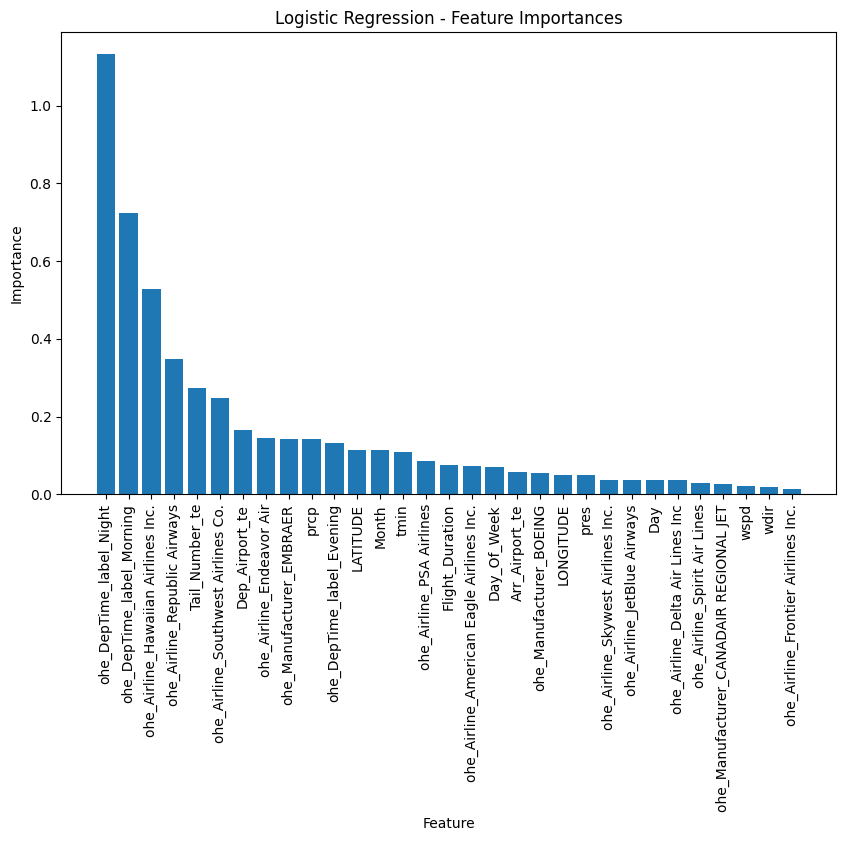

In [72]:
plot_feature_importance_logistic(rl_model, X_train_resampled.columns, "Logistic Regression")


Arvores

In [73]:
# RandomUndersampling of non-scaled dataframe

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Perform random undersampling on the training set
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_encoded, y_train)

# Print the shapes before and after
print(f"X_train_selected shape: {X_train_encoded.shape}")
print(f"X_train_resampled shape: {X_train_resampled.shape}")

X_train_selected shape: (337170, 31)
X_train_resampled shape: (255308, 31)


RandomForest

In [74]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

# Defining models
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "GradientBoost": GradientBoostingClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Training and evaluating models
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train_resampled, y_train_resampled)
    
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test_encoded)
    
    print(f"\n{model_name} - Training Classification Report:\n{classification_report(y_train_resampled, y_train_pred)}")
    print(f"\n{model_name} - Test Classification Report:\n{classification_report(y_test, y_test_pred)}")


Training RandomForest...

RandomForest - Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127654
           1       1.00      1.00      1.00    127654

    accuracy                           1.00    255308
   macro avg       1.00      1.00      1.00    255308
weighted avg       1.00      1.00      1.00    255308


RandomForest - Test Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71    209129
           1       0.54      0.61      0.57    128042

    accuracy                           0.66    337171
   macro avg       0.64      0.65      0.64    337171
weighted avg       0.67      0.66      0.66    337171


Training XGBoost...

XGBoost - Training Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70    127654
           1       0.70      0.66      0.68    127654



In [42]:
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    'n_estimators': np.arange(100, 500, 100),
    'max_depth': [5, 7, 10, 12, 15],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf, rf_params, scoring='f1', n_iter=20, cv=5, verbose=1, random_state=42, n_jobs=-1)
rf_search.fit(X_train_resampled, y_train_resampled)
best_random_rf = rf_search.best_estimator_
print("\nRandomForest - Best Estimator:\n", rf_search.best_params_)
print("\nRandomForest - Best Model Classification Report (Train):\n", classification_report(y_train_resampled, best_random_rf.predict(X_train_resampled)))
print("\nRandomForest - Best Model Classification Report (Test):\n", classification_report(y_test, best_random_rf.predict(X_test_encoded)))


Fitting 5 folds for each of 20 candidates, totalling 100 fits

RandomForest - Best Estimator:
 {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 15, 'bootstrap': False}

RandomForest - Best Model Classification Report (Train):
               precision    recall  f1-score   support

           0       0.79      0.82      0.80    127654
           1       0.81      0.78      0.79    127654

    accuracy                           0.80    255308
   macro avg       0.80      0.80      0.80    255308
weighted avg       0.80      0.80      0.80    255308


RandomForest - Best Model Classification Report (Test):
               precision    recall  f1-score   support

           0       0.74      0.69      0.72    209129
           1       0.55      0.61      0.58    128042

    accuracy                           0.66    337171
   macro avg       0.65      0.65      0.65    337171
weighted avg       0.67      0.66      0.66    337171



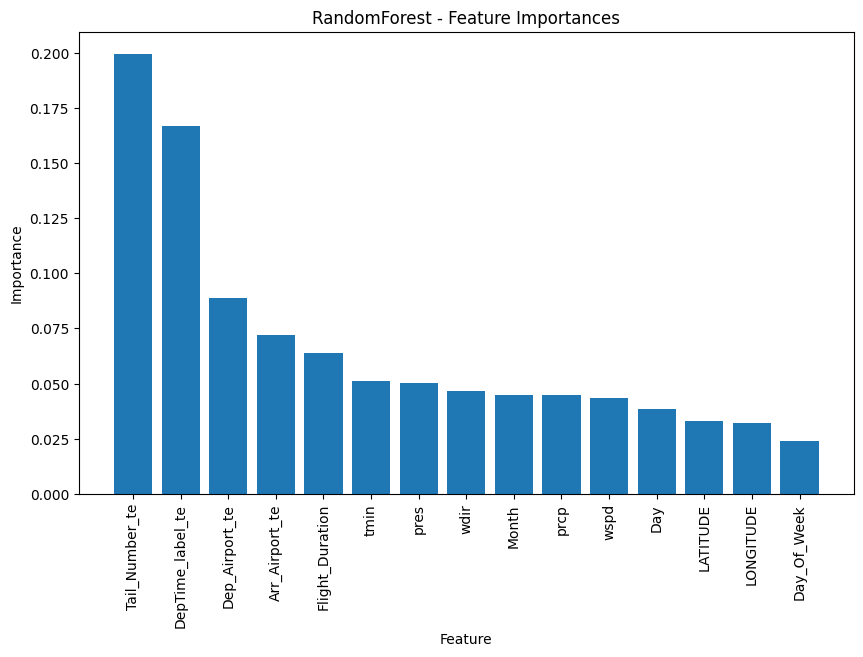

In [43]:
# Feature Importance for RandomForest
plot_feature_importance(best_random_rf, X_train_resampled.columns, "RandomForest")

In [44]:
y_pred_proba_rf = best_random_rf.predict_proba(X_test_encoded)[:, 1]
high_confidence_rf = y_pred_proba_rf > 0.9

y_pred_rf = best_random_rf.predict(X_test_encoded)
true_positives_rf = ((y_pred_rf == 1) & (y_test == 1) & high_confidence_rf).sum()
total_high_confidence_rf = high_confidence_rf.sum()

percentage_rf = (true_positives_rf / total_high_confidence_rf) * 100 if total_high_confidence_rf > 0 else 0
print(f"Random Forest - Percentage of True Positives (Class 1) with >90% Confidence: {percentage_rf:.2f}%")


Random Forest - Percentage of True Positives (Class 1) with >90% Confidence: 89.18%


In [75]:
from sklearn.model_selection import RandomizedSearchCV

# Randomized Search for XGBoost
xgb_params = {
    'n_estimators': np.arange(50, 450, 50),
    'max_depth': np.arange(3, 15, 2),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_search = RandomizedSearchCV(xgb, xgb_params, scoring='f1', n_iter=20, cv=5, verbose=1, random_state=42, n_jobs=-1)
xgb_search.fit(X_train_resampled, y_train_resampled)
best_random_xg = xgb_search.best_estimator_
print("\nXGBoost - Best Estimator:\n", xgb_search.best_params_)
print("\nXGBoost - Best Model Classification Report (Train):\n", classification_report(y_train_resampled, best_random_xg.predict(X_train_resampled)))
print("\nXGBoost - Best Model Classification Report (Test):\n", classification_report(y_test, best_random_xg.predict(X_test_encoded)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits

XGBoost - Best Estimator:
 {'subsample': 0.8, 'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.07444444444444444, 'colsample_bytree': 0.6}

XGBoost - Best Model Classification Report (Train):
               precision    recall  f1-score   support

           0       0.68      0.72      0.70    127654
           1       0.71      0.67      0.69    127654

    accuracy                           0.70    255308
   macro avg       0.70      0.70      0.70    255308
weighted avg       0.70      0.70      0.70    255308


XGBoost - Best Model Classification Report (Test):
               precision    recall  f1-score   support

           0       0.75      0.69      0.72    209129
           1       0.55      0.63      0.59    128042

    accuracy                           0.67    337171
   macro avg       0.65      0.66      0.66    337171
weighted avg       0.68      0.67      0.67    337171



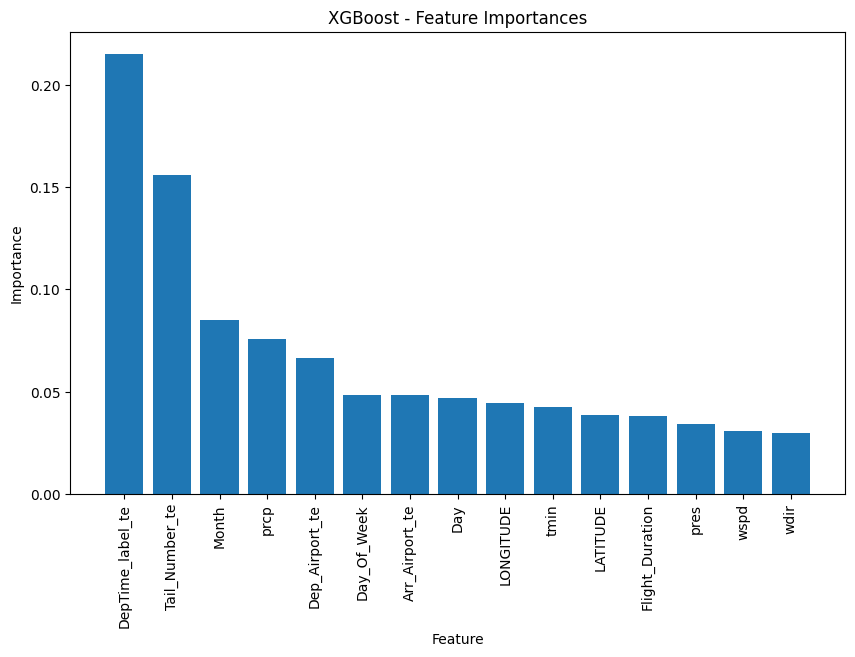

In [46]:
plot_feature_importance(best_random_xg, X_train_resampled.columns, "XGBoost")

In [47]:
y_pred_proba_xg = best_random_xg.predict_proba(X_test_encoded)[:, 1]
high_confidence_xg = y_pred_proba_xg > 0.90

y_pred_xg = best_random_xg.predict(X_test_encoded)
true_positives_xg = ((y_pred_xg == 1) & (y_test == 1) & high_confidence_xg).sum()
total_high_confidence_xg = high_confidence_xg.sum()

percentage_xg = (true_positives_xg / total_high_confidence_xg) * 100 if total_high_confidence_xg > 0 else 0
print(f"XGBoost - Percentage of True Positives (Class 1) with >90% Confidence: {percentage_xg:.2f}%")


XGBoost - Percentage of True Positives (Class 1) with >90% Confidence: 88.49%


In [76]:
import warnings
warnings.filterwarnings("ignore")

sys.stderr = open(os.devnull, "w")

# Randomized Search for LightGBM
lgbm_params = {
    'n_estimators': np.arange(50, 450, 100),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 15, 2),
    'num_leaves': np.arange(20, 150, 10),
    'subsample': [0.5, 0.6, 0.7, 0.8]
}
lgbm = LGBMClassifier(random_state=42)
lgbm_search = RandomizedSearchCV(lgbm, lgbm_params, scoring='f1', n_iter=20, cv=5, verbose=0, random_state=42, n_jobs=-1)
lgbm_search.fit(X_train_resampled, y_train_resampled)
best_random_gbm = lgbm_search.best_estimator_
print("\LightGBM - Best Estimator:\n", lgbm_search.best_params_)

print("\nLightGBM - Best Model Classification Report (Train):\n", classification_report(y_train_resampled, best_random_gbm.predict(X_train_resampled)))
print("\nLightGBM - Best Model Classification Report (Test):\n", classification_report(y_test, best_random_gbm.predict(X_test_encoded)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 127654, number of negative: 127654
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2668
[LightGBM] [Info] Number of data points in the train set: 255308, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

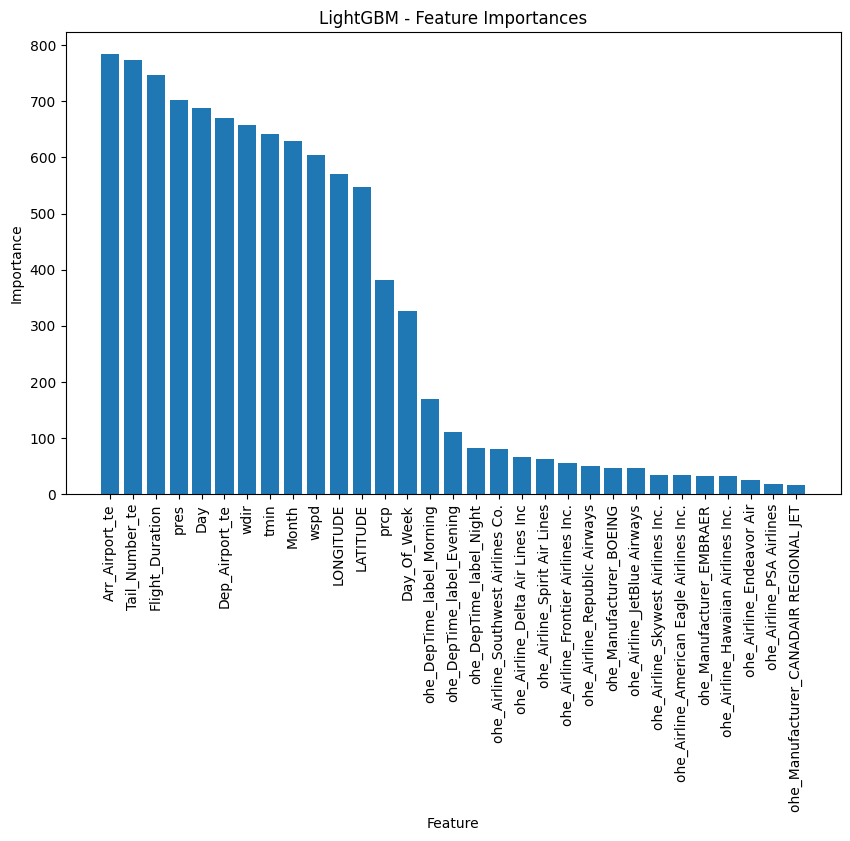

In [77]:
plot_feature_importance(best_random_gbm, X_train_resampled.columns, "LightGBM")

In [79]:
y_pred_proba_gbm = best_random_gbm.predict_proba(X_test_encoded)[:, 1]
high_confidence_gbm = y_pred_proba_gbm > 0.9

y_pred_gbm = best_random_gbm.predict(X_test_encoded)
true_positives_gbm = ((y_pred_gbm == 1) & (y_test == 1) & high_confidence_gbm).sum()
total_high_confidence_gbm = high_confidence_gbm.sum()

percentage_gbm = (true_positives_gbm / total_high_confidence_gbm) * 100 if total_high_confidence_gbm > 0 else 0
print(f"LightGBM - Percentage of True Positives (Class 1) with >90% Confidence: {percentage_gbm:.2f}%")


LightGBM - Percentage of True Positives (Class 1) with >90% Confidence: 88.90%


### Fine-Tuning and Hiperparams Search

XGBClassifier

In [61]:
# Define the objective function for optimization
def objective(params):
    # Initialize the XGBoost classifier with GPU settings
    xgb = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        tree_method='gpu_hist',  # Enable GPU acceleration
        gpu_id=0,  # Use the first GPU
        n_jobs=-1  # Utilize all available CPU cores for pre-processing
    )
    
    # Train the model
    xgb.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions
    y_pred_test = xgb.predict(X_test_encoded)
    
    # Compute the F1 score on the test set
    test_f1 = f1_score(y_test, y_pred_test)
    
    # Hyperopt minimizes the objective function, so we return the negative F1 score
    return {'loss': -test_f1, 'status': 'ok'}


In [53]:
best_random_xg.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.07444444444444444, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)>

In [58]:
from hyperopt import fmin, tpe, hp, Trials
from sklearn.metrics import f1_score

# Define the hyperparameter search space
space = {
    'n_estimators': hp.quniform('n_estimators', 225, 275, 5),
    'max_depth': hp.quniform('max_depth', 5, 10, 0.5),
    'learning_rate': hp.quniform('learning_rate', 0.05, 0.1, 0.001),
    'subsample': hp.choice('subsample', [0.6, 0.65, 0.7, 0.75, 0.8]),  
    'colsample_bytree': hp.choice('colsample_bytree', [0.5, 0.55, 0.6, 0.65, 0.7])  
}

# Initialize trials object to track results
trials = Trials()

# Random number generator
rstate = np.random.default_rng(42)

# Run optimization using Tree-structured Parzen Estimator (TPE)
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)

# Define the correct lookup lists for categorical hyperparameters
subsample_values = [0.6, 0.65, 0.7, 0.75, 0.8]
colsample_bytree_values = [0.5, 0.55, 0.6, 0.65, 0.7]

# Print the best hyperparameters found by Hyperopt
print("\nBest Hyperparameters found by Hyperopt:")
print(best)

# Train the best model with the selected hyperparameters
best_model_xgb = XGBClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=subsample_values[best['subsample']],
    colsample_bytree=colsample_bytree_values[best['colsample_bytree']], 
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    tree_method='gpu_hist',
    gpu_id=0,
    n_jobs=-1
)

# Train the best model on the training data
best_model_xgb.fit(X_train_resampled, y_train_resampled)

# Make predictions on training and testing sets
y_pred_train_best = best_model_xgb.predict(X_train_resampled)
y_pred_test_best = best_model_xgb.predict(X_test_encoded)

# Print the classification report for the training set
print("\nBest Model Classification Report (Train):\n", classification_report(y_train_resampled, y_pred_train_best))

# Print the classification report for the test set
print("\nBest Model Classification Report (Test):\n", classification_report(y_test, y_pred_test_best))

100%|██████████| 50/50 [01:51<00:00,  2.22s/trial, best loss: -0.6355102232080099]

Best Hyperparameters found by Hyperopt:
{'colsample_bytree': 0, 'learning_rate': 0.094, 'max_depth': 9.0, 'n_estimators': 230.0, 'subsample': 4}

Best Model Classification Report (Train):
               precision    recall  f1-score   support

           0       0.75      0.78      0.76    127654
           1       0.77      0.73      0.75    127654

    accuracy                           0.76    255308
   macro avg       0.76      0.76      0.76    255308
weighted avg       0.76      0.76      0.76    255308


Best Model Classification Report (Test):
               precision    recall  f1-score   support

           0       0.75      0.68      0.71    209129
           1       0.55      0.64      0.59    128042

    accuracy                           0.66    337171
   macro avg       0.65      0.66      0.65    337171
weighted avg       0.67      0.66      0.67    337171



In [69]:
y_pred_proba_xg = best_model_xgb.predict_proba(X_test_encoded)[:, 1]
high_confidence_xg = y_pred_proba_xg > 0.90

y_pred_xg = best_model_xgb.predict(X_test_encoded)
true_positives_xg = ((y_pred_xg == 1) & (y_test == 1) & high_confidence_xg).sum()
total_high_confidence_xg = high_confidence_xg.sum()

percentage_xg = (true_positives_xg / total_high_confidence_xg) * 100 if total_high_confidence_xg > 0 else 0
print(f"XGBoost - Percentage of True Positives (Class 1) with >90% Confidence: {percentage_xg:.2f}%")


XGBoost - Percentage of True Positives (Class 1) with >90% Confidence: 90.10%


In [81]:
best_random_gbm.get_params

<bound method LGBMModel.get_params of LGBMClassifier(learning_rate=0.1388888888888889, max_depth=5, n_estimators=350,
               num_leaves=100, random_state=42, subsample=0.7)>

In [100]:
from hyperopt import fmin, tpe, hp, Trials
import lightgbm as lgb
import numpy as np
from sklearn.metrics import f1_score, classification_report
import warnings

warnings.filterwarnings("ignore")

def objective(params):
    model = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=42,
        n_jobs=-1,
        device='gpu',
        verbose=-1
    )
    
    model.fit(X_train_resampled, y_train_resampled)
    y_pred_test = model.predict(X_test_encoded)
    test_f1 = f1_score(y_test, y_pred_test)
    
    return {'loss': -test_f1, 'status': 'ok'}

space = {
    'n_estimators': hp.quniform('n_estimators', 325, 375, 5),
    'max_depth': hp.quniform('max_depth', 3, 8, 0.5),
    'learning_rate': hp.quniform('learning_rate', 0.1, 0.15, 0.005),
    'subsample': hp.choice('subsample', [0.6, 0.65, 0.7, 0.75, 0.8]),
    'num_leaves': hp.choice('num_leaves', [31, 50, 100, 150, 200]),  
    'colsample_bytree': hp.choice('colsample_bytree', [0.5, 0.55, 0.6, 0.65, 0.7])  
}

trials = Trials()
rstate = np.random.default_rng(42)

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)

subsample_values = [0.6, 0.65, 0.7, 0.75, 0.8]
colsample_bytree_values = [0.5, 0.55, 0.6, 0.65, 0.7]

best_model = lgb.LGBMClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=subsample_values[best['subsample']],
    colsample_bytree=colsample_bytree_values[best['colsample_bytree']],
    random_state=42,
    n_jobs=-1,
    device='gpu',
    verbose=-1
)

best_model.fit(X_train_resampled, y_train_resampled)
y_pred_train_best = best_model.predict(X_train_resampled)
y_pred_test_best = best_model.predict(X_test_encoded)

train_report = classification_report(y_train_resampled, y_pred_train_best)
test_report = classification_report(y_test, y_pred_test_best)

print("\nBest Model Classification Report (Train):\n", train_report)
print("\nBest Model Classification Report (Test):\n", test_report)



100%|██████████| 50/50 [02:39<00:00,  3.20s/trial, best loss: -0.5902808445409587]

Best Model Classification Report (Train):
               precision    recall  f1-score   support

           0       0.68      0.71      0.69    127654
           1       0.70      0.66      0.68    127654

    accuracy                           0.69    255308
   macro avg       0.69      0.69      0.69    255308
weighted avg       0.69      0.69      0.69    255308


Best Model Classification Report (Test):
               precision    recall  f1-score   support

           0       0.75      0.69      0.72    209129
           1       0.55      0.63      0.59    128042

    accuracy                           0.67    337171
   macro avg       0.65      0.66      0.65    337171
weighted avg       0.68      0.67      0.67    337171



Random Forest

In [ ]:
from sklearn.metrics import make_scorer, f1_score

# Define the parameter grid for XGBoost
param_dist = {
    "n_estimators": [100, 150, 200, 300],
    "max_depth": [5, 7, 10, 12, 15],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "scale_pos_weight": [10, 20, 30, 40],
    "gamma": [0, 0.1, 0.2],
    "min_child_weight": [1, 5, 10],
}

# Create the XGBClassifier
xgb = XGBClassifier(
    random_state=42,
    objective='binary:logitraw',
    eval_metric='logloss',
)

# Create the RandomizedSearchCV object with precision as the scoring metric
random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring=make_scorer(f1_score, pos_label=1),
)

# Run RandomizedSearchCV with progress bar
random_search.fit(X_train_undersampled, y_train_undersampled)

# Print the best parameters and best precision score found
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

# Use the best estimator from the RandomizedSearchCV
best_xgb_model = random_search.best_estimator_

# Evaluate the model on both training and test sets
evaluate_model(best_xgb_model, X_train_undersampled, y_train_undersampled, X_test_encoded, y_test)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}
Best score found:  0.6797433092763089
Classification Report (Train) for XGBClassifier:
              precision    recall  f1-score   support

         0.0       1.00      0.22      0.37     69270
         1.0       0.56      1.00      0.72     69270

    accuracy                           0.61    138540
   macro avg       0.78      0.61      0.54    138540
weighted avg       0.78      0.61      0.54    138540

Classification Report (Test) for XGBClassifier:
              precision    recall  f1-score   support

         0.0       0.92      0.13      0.23    618484
         1.0       0.24      0.96      0.38    173081

    accuracy                           0.31    791565
   macro avg       0.58      0.54      0.30    791565
weighted avg    

In [ ]:
# Define the parameter grid for GradientBoostingClassifier
param_dist = {
    "n_estimators": [100, 150, 200],  # Number of boosting stages (similar to n_estimators in XGBoost)
    "max_depth": [3, 5, 10],  # Maximum depth of each tree
    "learning_rate": [0.01, 0.1, 0.2],  # Step size shrinking to make the model more robust
    "subsample": [0.7, 0.8, 0.9],  # Fraction of samples to use for fitting each tree (analogous to subsample in XGBoost)
    "min_samples_split": [2, 5, 10],  # The minimum number of samples required to split an internal node
    "min_samples_leaf": [1, 2, 4],  # The minimum number of samples required to be at a leaf node
    "max_features": ["sqrt", "log2", None],  # The number of features to consider when looking for the best split
}

# Create the GradientBoostingClassifier
gb = GradientBoostingClassifier(
    random_state=42,
    loss='log_loss',  # Logarithmic loss (log loss) for binary classification
)

# Create the RandomizedSearchCV object with F1-score as the scoring metric
random_search = RandomizedSearchCV(
    gb,
    param_distributions=param_dist,
    n_iter=10,  # Number of random attempts
    cv=3,  # 3-fold cross-validation
    verbose=2,  # Print details during the search
    random_state=42,
    n_jobs=-1,  # Use all available CPU cores
    scoring='precision',  # F1-score for class 1 
)


# Run RandomizedSearchCV with progress bar
random_search.fit(X_train_undersampled, y_train_undersampled)

# Print the best parameters and best F1-score found
print("Best parameters found: ", random_search.best_params_)
print("Best F1-score found: ", random_search.best_score_)

# Use the best estimator from the RandomizedSearchCV
best_gb_model = random_search.best_estimator_

# Evaluate the model on both training and test sets
evaluate_model(best_gb_model, X_train_undersampled, y_train_undersampled, X_test_encoded, y_test)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'subsample': 0.9, 'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'learning_rate': 0.1}
Best F1-score found:  0.6666468421156634
Classification Report (Train) for GradientBoostingClassifier:
              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75    172896
         1.0       0.76      0.72      0.74    172896

    accuracy                           0.75    345792
   macro avg       0.75      0.75      0.75    345792
weighted avg       0.75      0.75      0.75    345792

Classification Report (Test) for GradientBoostingClassifier:
              precision    recall  f1-score   support

         0.0       0.87      0.69      0.77    618484
         1.0       0.36      0.64      0.46    173081

    accuracy                           0.68    791565
   macro avg       0.62      0.66      0.62    791565
w

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module='lightgbm')

# Define the parameter grid for LGBMClassifier
param_dist = {
    "n_estimators": [100, 150, 200, 250, 300],  # Number of boosting iterations (similar to n_estimators in XGBoost)
    "max_depth": [3, 5, 7, 10, 12, 15],  # Maximum depth of each tree
    "learning_rate": [0.01, 0.1, 0.2],  # Step size shrinking to make the model more robust
    "subsample": [0.7, 0.8, 0.9],  # Fraction of samples to use for fitting each tree
    "colsample_bytree": [0.7, 0.8, 0.9],  # Fraction of features to consider when building each tree
    "scale_pos_weight": [1, 10, 20],  # Used to scale the weight of the positive class (helps with imbalanced classes)
    "min_child_samples": [10, 20, 30],  # Minimum number of samples a leaf node must have
    "min_child_weight": [1, 5, 10],  # Minimum sum of instance weight (hessian) needed in a child
    "reg_alpha": [0, 0.1, 0.5],  # L1 regularization term on weights
    "reg_lambda": [0, 0.1, 0.5],  # L2 regularization term on weights
}

# Create the LGBMClassifier
lgbm = lgb.LGBMClassifier(
    random_state=42,
    objective='binary',  # Binary classification problem
    metric='binary_logloss',  # Binary log loss as the evaluation metric
)

# Create the RandomizedSearchCV object with F1-score as the scoring metric
random_search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist,
    n_iter=10,  # Number of random attempts
    cv=5,  # 3-fold cross-validation
    verbose=0,  # Print details during the search
    random_state=42,
    n_jobs=-1,  # Use all available CPU cores
    scoring='f1_macro',  # F1-score for class 1 
)

# Run RandomizedSearchCV with progress bar
random_search.fit(X_train_undersampled, y_train_undersampled)

# Print the best parameters and best F1-score found
print("Best parameters found: ", random_search.best_params_)
print("Best F1-score found: ", random_search.best_score_)

# Use the best estimator from the RandomizedSearchCV
best_lgbm_model = random_search.best_estimator_

# Evaluate the model on both training and test sets
evaluate_model(best_lgbm_model, X_train_undersampled, y_train_undersampled, X_test_encoded, y_test)


[LightGBM] [Info] Number of positive: 69270, number of negative: 69270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3443
[LightGBM] [Info] Number of data points in the train set: 138540, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best parameters found:  {'subsample': 0.9, 'scale_pos_weight': 1, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 5, 'min_child_samples': 10, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best F1-score found:  0.6530801184702341
[LightGBM] [Info] Number of positive: 69270, number of negative: 69270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3443
[LightGBM] [Info] 

In [ ]:
# Import necessary libraries
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

categorical_features = features_cat + features_id

# Define the CatBoost model
catboost_model = CatBoostClassifier(iterations=1000, depth=10, learning_rate=0.1, loss_function='Logloss', verbose=0)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'iterations': randint(100, 500),  # Number of boosting iterations (lower range)
    'depth': randint(3, 8),  # Maximum depth of the trees (smaller range)
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate (fewer options)
    'l2_leaf_reg': [1, 5, 10],  # L2 regularization term (fewer options)
    'border_count': randint(32, 100),  # Number of splits for numeric features (smaller range)
    'max_ctr_complexity': [1, 2]  # Maximum complexity of categorical feature combinations (fewer options)
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(catboost_model, param_distributions=param_dist, n_iter=20, scoring='f1', cv=3, 
                                   verbose=0, random_state=42, error_score='raise')

# Fit the RandomizedSearchCV to find the best parameters
print("Starting Randomized Search...")
random_search.fit(X_train, y_train, cat_features=categorical_features)

# Output the best parameters and the best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test Set Accuracy: {test_score}")


Deep Learning

In [ ]:
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import time

import warnings
warnings.simplefilter("ignore")  # Suppresses warnings


# Define the model with the updated parameters
mlp = MLPClassifier(
    random_state=42,                    # Ensures reproducibility
    warm_start=False                    # No incremental training, starting fresh each time
)

# Define the hyperparameters for RandomizedSearchCV
# param_dist = {
#     'hidden_layer_sizes': [(100,), (100, 50), (100, 50, 25), (200, 100, 50)],
#     'activation': ['relu', 'tanh'],
#     'solver': ['adam', 'sgd'],
#     'batch_size': [128, 512, 1024],
#     'max_iter': [10, 50, 100],
# }

param_dist = {
    'hidden_layer_sizes': [(100,), (100, 50), (100, 50, 25)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'batch_size': [128, 1024],
    'max_iter': [10, 50],
}

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, verbose=1)

# Use tqdm to create a friendly progress bar for the training loop
epochs = 50
progress_bar = tqdm(range(epochs), desc="Training Progress", unit="epoch", ascii="->")

# NearMiss 1
for _ in progress_bar:
    random_search.fit(X_train_resampled_1, y_train_resampled_1)

# Make predictions
y_pred_train_mlp = random_search.predict(X_train_resampled_1)
y_pred_test_mlp = random_search.predict(X_test_scaled)

# Evaluate the model
print("Train Classification Report:")
print(classification_report(y_train_resampled_1, y_pred_train_mlp))
print("-" * 60)

print("Test Classification Report:")
print(classification_report(y_test, y_pred_test_mlp))
print("-" * 60)